<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
<center>Автор материала: Лозовой Виталий Витальевич, @vitaliylo.

# <center>Тьюториал по Tensorflow Hub</center>
## <center>Получаем сложные признаки простым способом</center>

Так уж сложилось что искуственные нейронные сети сейчас в почете. Тема нейронных сетей довольно сложная и местами неоднозначная. Для большинства задач, когда есть четкие признаки - "классические" алгоритмы машинного обучения справляются лучше, но в задачах когда признаки сильно абстрактные(большинство задач работы с изображениями, и большая часть текстовых задач) - глубоким нейронным сетям нет равных. Но нейронная сеть - штука громоздкая, нужно много данных, часто для обучения требуются дни, а чтобы хоть как-то ускорить процес - может понадобится не один GPU. Поетому часто можно наити готовые, предобученые модели для некоторых задач. Сегодня я расскажу именно о таком случае.

Мы посмотрим что из себя представляет Tensorflow Hub и как его можно использовать не для глубокого обучения. 

#### Начнем с начала:
<a href="https://en.wikipedia.org/wiki/TensorFlow">Tensorflow</a> - библиотека глубокого обучения от Google, отчасти написана <a href="https://en.wikipedia.org/wiki/Jeff_Dean_(computer_scientist)">Ним Самым</a>. Ее в качестве бекенда может использовать популярный фреймворк Keras, и в ней есть как объекты высокого уровня (estimators, layers), так и возможность писать всю математику самому.
К сожалению тема слишком обширная чтоб ее разворачивать в маленьком туториале, да и он не об этом.
#### А о чем?
Туториал будет об использовании <a href="https://www.tensorflow.org/hub/">Tensorflow hub</a> - модуле с готовыми обучеными моделями и их частями. Это некий ящик с инструментами, который может помочь сэкономить время обучения нейронных сетей(transfer learning) или **сгенерировать признаки высокого уровня абстракции**.
#### Как?
Начнем с установки:

In [ ]:
!pip install tensorflow
#pip install tensorflow-gpu # для тех у кого установлена CUDA
!pip install tensorflow-hub

In [61]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from scipy.spatial import distance
import os
import pandas as pd
import re
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub

from PIL import Image, ImageOps
from scipy.spatial import cKDTree
from skimage.feature import plot_matches
from skimage.measure import ransac
from skimage.transform import AffineTransform

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
# константа для задания размеров графиков
FIGSIZE_TUPLE = (12, 9)

# настройка внешнего вида графиков в seaborn
sns.set_context(
    "notebook", 
    font_scale = 1.5,      
    rc = { 
        "figure.figsize" : FIGSIZE_TUPLE, 
        "axes.titlesize" : 18 
    }
)
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':FIGSIZE_TUPLE}, font_scale=1.5)
from matplotlib import rcParams
rcParams['figure.figsize'] = FIGSIZE_TUPLE


Посмотрим что он умеет. Вот список моделей в наличии:
- delf - сеть анализа изображений, натренирована на фотографиях достопримечательностей
- imagenet - целая пачка моделей разных типов и размеров, которые принимали участие в imagenet в разные годы
- progan - генеративная сеть обученая на фото знаменитостей
- elmo - text embedding
- nnlm - text embedding с обработкой out of vocabulary. Есть версии для разных размеров выходных векторов и разных языков(русского нет).
- universal sentance encoder - это уже что-то ближе к doc2vec. Модуль заточен на semantic similarity
- wiki-words - снова word2vec, обученый на английской wiki

Довольно много всякого.
#### А как я могу это использовать?
Можно получать из текстов - "смысловой вектор". Это простейший из способов получить doc2vec который мне известен

In [2]:
# Качаем модель. В первый раз занимает достаточно много времени.
embed = hub.Module("https://tfhub.dev/google/universal-sentence-encoder/1")

INFO:tensorflow:Using C:\Users\vuzya\AppData\Local\Temp\tfhub_modules to cache modules.
INFO:tensorflow:Initialize variable module/Embeddings_en/sharded_0:0 from checkpoint b'C:\\Users\\vuzya\\AppData\\Local\\Temp\\tfhub_modules\\c6f5954ffa065cdb2f2e604e740e8838bf21a2d3\\variables\\variables' with Embeddings_en/sharded_0
INFO:tensorflow:Initialize variable module/Embeddings_en/sharded_1:0 from checkpoint b'C:\\Users\\vuzya\\AppData\\Local\\Temp\\tfhub_modules\\c6f5954ffa065cdb2f2e604e740e8838bf21a2d3\\variables\\variables' with Embeddings_en/sharded_1
INFO:tensorflow:Initialize variable module/Embeddings_en/sharded_10:0 from checkpoint b'C:\\Users\\vuzya\\AppData\\Local\\Temp\\tfhub_modules\\c6f5954ffa065cdb2f2e604e740e8838bf21a2d3\\variables\\variables' with Embeddings_en/sharded_10
INFO:tensorflow:Initialize variable module/Embeddings_en/sharded_11:0 from checkpoint b'C:\\Users\\vuzya\\AppData\\Local\\Temp\\tfhub_modules\\c6f5954ffa065cdb2f2e604e740e8838bf21a2d3\\variables\\variables

In [38]:
# Он любит спамить в лог. Если мы не любопытны к чужим логам - лучше отключить.
tf.logging.set_verbosity(tf.logging.ERROR)

with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  embeddings = session.run(embed(['word']))

  print("Слово: word")
  print("Размер смыслового вектора: {}".format(len(embeddings[0])))
  print("Часть вектора: {}, ...\n".format(embeddings[0][::10]))

Слово: word
Размер смыслового вектора: 512
Часть вектора: [[ 0.02660226  0.02066064 -0.0299476   0.01173687  0.00814954  0.01418396
  0.00627    -0.03721272  0.01782784  0.03114282 -0.00844167  0.00584005
 -0.00892869  0.01119984  0.07796927 -0.05301265 -0.08894788 -0.02116829
 -0.05117911 -0.03442282  0.05544387  0.09847693  0.02022452  0.04937643
  0.01315609  0.01696187  0.03444507  0.04289608 -0.05671757  0.02320517
 -0.05810449  0.08426362  0.0088862   0.07461585 -0.03999101  0.06130065
 -0.04615525 -0.00914216  0.07119901 -0.03390864  0.0271626  -0.02233593
  0.01537044  0.09589078  0.0725631  -0.01088397  0.03045     0.0135767
 -0.01586043 -0.00039048  0.05122505 -0.08420416], ...]



Модель называется universal **sentance** encoder, поетому давайте попробуем на предложениях

In [34]:
sentences = [
    # You know...
    "I really love to study data science, specially deep learning",
    "Machine learning is cool. I like to do it",
    "Neural networks are not so hard when you use tensorflow hub.",

    # Travelling
    "I'm a hitchhiker.",
    'Whay kind of travelling do you prefere?',
    "This year I've visited a few foreign countries",
    "Have you ever been in a long trip?",

    # Weather?
    "Nice weather isn't it?",
    "Looks like it's hot today",
    "Do you believe in global warming?",
    
    # Fastfood
    'KFC',
    'McDonalds',
    'Dominos',
    
    # Graphomania
    "I can even write a very long text here. Somehow the long text can anyway have some general meaning. There's a lot of words",
    "War and Peace",
    "Leo Tolstoy",
  
    "Tesla",
    "AC/DC",
    "Rock",
    "Car with autopilot"
]

Прогоним наши фразы через doc2vec, и попробуем найти степень схожести векторов друг с другом

In [35]:
def run_and_plot(session_, input_tensor_, messages_, encoding_tensor):
  message_embeddings_ = session_.run(
      encoding_tensor, feed_dict={input_tensor_: messages_})
  messages_ = list(map(lambda m: m[:25]+'...' if len(m)>30 else m, messages_))
  g = sns.heatmap(
      np.inner(message_embeddings_, message_embeddings_),
      xticklabels=messages_,
      yticklabels=messages_,
      vmin=0,
      vmax=1,
      cmap="Blues")
  g.set_xticklabels(messages_, rotation=90)
  g.set_title("Semantic Textual Similarity")

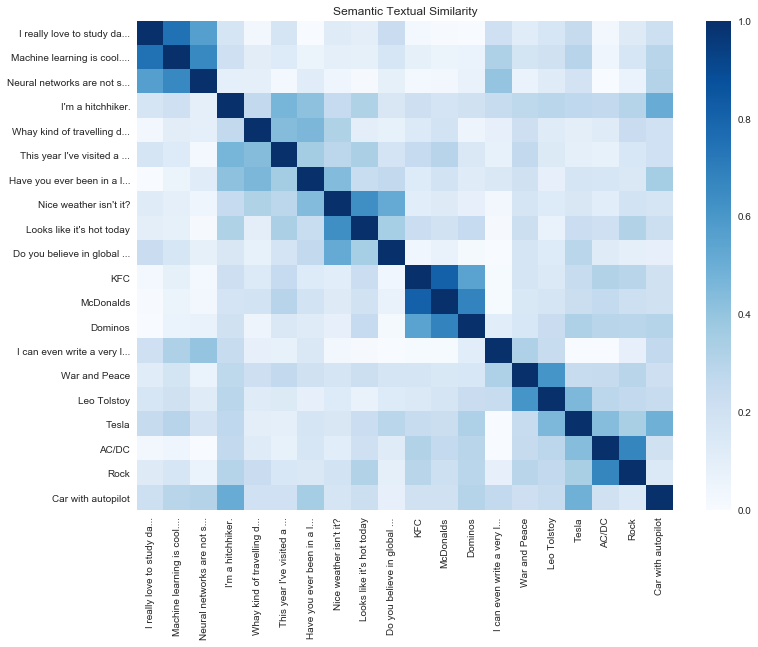

In [36]:
similarity_input_placeholder = tf.placeholder(tf.string, shape=(None))
similarity_encodings = embed(similarity_input_placeholder)
with tf.Session() as session:
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  run_and_plot(session, similarity_input_placeholder, sentences,
               similarity_encodings)

Как видим - даже из многословных текстов можна выжать некий смысл который будет иметь видимую корреляцию со сходными понятиями или понятиями из схожего контекста. К сожалению чем больше текста в каждом примере, тем менее строго будут коррелировать понятия, так как большой текст имеет гораздо более разнообразный смысл, чем одно слово.
#### Что там еще?
Таким же образом мы можем поступить и с картинками - используя `hub.Module("https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1")` из пакета imagenet - он даст вектор из 2048 признаков, которые нейросеть нашла на картинке.
Интересная модель delf - она позволяет найти "важные" точки на картинке и соответствующие им векторы признаков. Таким образом можно сравнивать картинки

In [48]:
tf.reset_default_graph()
tf.logging.set_verbosity(tf.logging.INFO)

m = hub.Module('https://tfhub.dev/google/delf/1') # Это будет долго

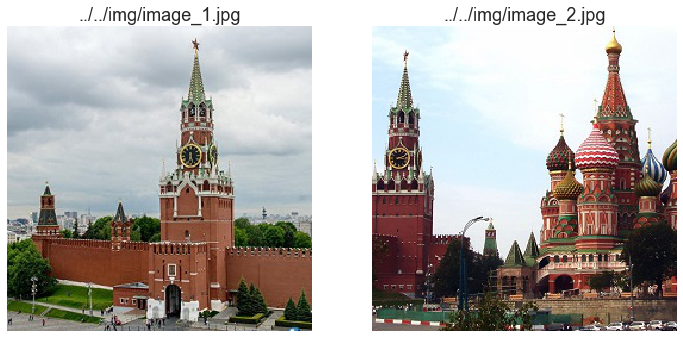

In [58]:
IMAGE_1 = "../../img/image_1.jpg"
IMAGE_2 = "../../img/image_2.jpg"

def show_images(image_path_list):
  plt.figure()
  for i, image_path in enumerate(image_path_list):
    plt.subplot(1, len(image_path_list), i+1)
    plt.imshow(np.asarray(Image.open(image_path)))
    plt.title(image_path)
    plt.grid(False)
    plt.yticks([])
    plt.xticks([])
  plt.show()

show_images([IMAGE_1, IMAGE_2])

In [52]:
def image_input_fn():
  filename_queue = tf.train.string_input_producer(
      [IMAGE_1, IMAGE_2], shuffle=False)
  reader = tf.WholeFileReader()
  _, value = reader.read(filename_queue)
  image_tf = tf.image.decode_jpeg(value, channels=3)
  return tf.image.convert_image_dtype(image_tf, tf.float32)

In [59]:
image_placeholder = tf.placeholder(
    tf.float32, shape=(None, None, 3), name='input_image')

module_inputs = {
    'image': image_placeholder,
    'score_threshold': 100.0,
    'image_scales': [0.25, 0.3536, 0.5, 0.7071, 1.0, 1.4142, 2.0],
    'max_feature_num': 1000,
}

module_outputs = m(module_inputs, as_dict=True)

image_tf = image_input_fn()

with tf.train.MonitoredSession() as sess:
  results_dict = {}  # Stores the locations and their descriptors for each image
  for image_path in [IMAGE_1, IMAGE_2]:
    image = sess.run(image_tf)
    print('Extracting locations and descriptors from %s' % image_path)
    results_dict[image_path] = sess.run(
        [module_outputs['locations'], module_outputs['descriptors']],
        feed_dict={image_placeholder: image})

Extracting locations and descriptors from ../../img/image_1.jpg
Extracting locations and descriptors from ../../img/image_2.jpg


На картинке image 1 нашлось 152 признаков
На картинке image 2 нашлось 203 признаков
Найдено 56 точек


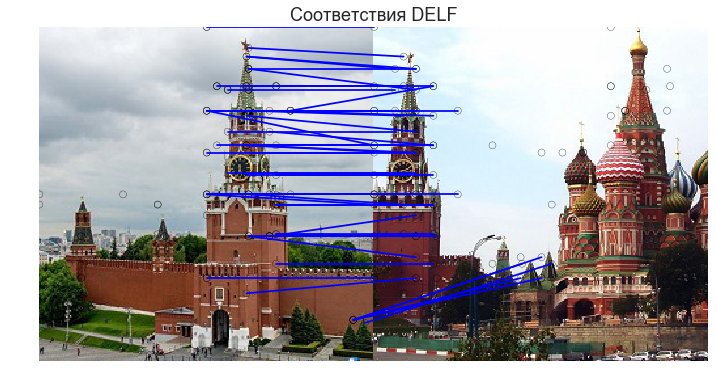

In [64]:
distance_threshold = 0.8

locations_1, descriptors_1 = results_dict[IMAGE_1]
num_features_1 = locations_1.shape[0]
print("На картинке image 1 нашлось %d признаков" % num_features_1)
locations_2, descriptors_2 = results_dict[IMAGE_2]
num_features_2 = locations_2.shape[0]
print("На картинке image 2 нашлось %d признаков" % num_features_2)

# среди признаков поиещем похожие с помощью KD tree.
d1_tree = cKDTree(descriptors_1)
_, indices = d1_tree.query(
    descriptors_2, distance_upper_bound=distance_threshold)

# Select feature locations for putative matches.
locations_2_to_use = np.array([
    locations_2[i,]
    for i in range(num_features_2)
    if indices[i] != num_features_1
])
locations_1_to_use = np.array([
    locations_1[indices[i],]
    for i in range(num_features_2)
    if indices[i] != num_features_1
])

# Разделяем на выбросы и обычные точки с помощью RANdom SAmple Consensus.
_, inliers = ransac(
    (locations_1_to_use, locations_2_to_use),
    AffineTransform,
    min_samples=3,
    residual_threshold=20,
    max_trials=1000)

print('Найдено %d точек' % sum(inliers))

# Отрисуем связи которые модель нашла.
_, ax = plt.subplots()
inlier_idxs = np.nonzero(inliers)[0]
plot_matches(
    ax,
    mpimg.imread(IMAGE_1),
    mpimg.imread(IMAGE_2),
    locations_1_to_use,
    locations_2_to_use,
    np.column_stack((inlier_idxs, inlier_idxs)),
    matches_color='b')
ax.axis('off')
ax.set_title('Соответствия DELF');

### Заключение
Иногда хочется получить преимущества глубокого обучения без недостатков этого самого глубокого обучения. Я считаю что tensorflow hub - полезный инструмент в арсенале, особенно в случаях когда:
- Нет времени/желания/навыка/вычислительных ресурсов обучить полноценную глубокую нейронную сеть
- Нужна предобученая модел для теплого старта
- Нужно получить фичи нейронной сети, а не использовать ее как полноценную модель
- Нужна полноценная модель, но быстро и дешево

Рекомендую всем скачать и поиграться, это как минимум интересно.

_П.С. Да, он криво заматчил ёлочки с крышами_ ¯\&#95;(ツ)&#95;/¯